In [70]:
# data analysis and wrangling
import math
import numpy 
import pandas 
import random
import scipy.stats

# visualization
import seaborn ; seaborn.set(style='whitegrid') # nicer plotting style
import matplotlib.pyplot as pyplot
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
pandas.options.display.max_columns = None  # to display all the columns

In [71]:
import matplotlib.gridspec as gridspec

# Boxplots with histograms above
def plot_boxplot_with_hist(df_input, target='SalePrice', ncols=5, figsize=(20, 32)):
    
    unique_count = df_input.nunique()
    df = df_input[list(unique_count[unique_count <= 25].index) + ['SalePrice']].copy()
    nrows = math.ceil((df.shape[1] - 1) / ncols) 
    
    row_width_increment = 1 / ncols
    col_width_decrement = 1 / nrows

    fig = pyplot.figure(figsize=figsize)

    for count, col in enumerate(df.columns.drop(target)):
        col_num, row_num = count % ncols, count // ncols
        left = row_width_increment * col_num
        right = row_width_increment * (col_num + 1) - 0.05
        top = 1 - row_num * col_width_decrement
        bottom = 1.03 - (row_num + 1) * col_width_decrement 

        gs1 = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=(.3, .7), left=left, bottom=bottom, top=top, right=right, hspace=0.05)
        hist_ax = fig.add_subplot(gs1[0]) ; hist_ax.tick_params(axis='x', which='major', pad=.1)
        seaborn.countplot(x=col, data=df, ax=hist_ax)
        box_ax = fig.add_subplot(gs1[1]) ; box_ax.tick_params(axis='x', which='major', pad=.1)
        seaborn.boxplot(x=col, y=target, data=df, ax=box_ax)
        
        if df[col].dtype == 'O':
            hist_ax.set_xticklabels(hist_ax.get_xticklabels(), rotation=45) 
            box_ax.set_xticklabels(box_ax.get_xticklabels(), rotation=45) 
        
        if col_num != 0:
            hist_ax.set_ylabel('')
            box_ax.set_ylabel('')

# Scatter plots between the features and the target 
def plot_pairwise_with_target(df_input, target='SalePrice', ncols=6):
    
    unique_count = df_input.nunique()
    df = df_input[list(unique_count[unique_count > 25].index)].drop('Id', axis=1)
    nrows = math.ceil((df.shape[1] - 1) / ncols) 
    
    fig, ax = pyplot.subplots(nrows=nrows, ncols=ncols, figsize=(20, 11), sharey='row')
    
    for count, col in enumerate(df.columns.drop(target)):
        this_ax = ax[count // ncols][count % ncols]
        seaborn.regplot(x=col, y=target, data=df, color='b', fit_reg=False, scatter_kws={'s': 10, 'alpha': 0.5}, ax=this_ax)  
        #this_ax.set_xticklabels(this_ax.get_xticklabels(), rotation=45) 
        if count % ncols != 0:
            ax[count // ncols][count % ncols].set_ylabel('')
            
# Correlation matrix (upper triangle)          
def plot_correlation_map(df, figsize=(18,18)):
    
    corr = df.corr()
    
    # Generate a mask for the upper triangle
    mask = numpy.zeros_like(corr, dtype=numpy.bool)
    mask[numpy.triu_indices_from(mask)] = True
    
    _ , ax = pyplot.subplots(figsize=figsize)
    _ = seaborn.heatmap(
        corr, 
        mask=mask,
        cmap="RdBu_r",
        square=True, 
        cbar_kws={'shrink': .7}, 
        ax=ax, 
        annot=False, 
        annot_kws={'fontsize': 9}
    )

# I) Exploratory Data Analysis


- Data extraction
- Preprocessing and cleaning
- Plotting (distributions, pairwise relations, correlations)
- Assumptions

### Data Extraction


**Load both the train and the test sets and see what they look like.**

- both data sets have a similar shape: `df_train` has 79 potential features, 1 target (`SalePrice`) and 1460 obs, and `df_test` has 79 features and 1459 obs


In [72]:
# Load both data sets
df_train = pandas.read_csv('CSVs/train.csv')
df_test = pandas.read_csv('CSVs/test.csv')

# Store both data sets in one dictionary in order to make each transformation step easier and clearer
data_sets = {'df_train': df_train, 'df_test': df_test}

In [73]:
print(data_sets['df_train'].shape, data_sets['df_test'].shape)
data_sets['df_train'].head(2)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [74]:
data_sets['df_test'].head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


### Preprocessing and cleaning

**Show the data types (check whether train and test are similar in that sense).**

- There are some differences in the numerical types of 8 columns (if we exclude `SalePrice`), but in this case it's not an issue: int64 and float64 can be used interchangeably.


**Show the number of missing values.**

We count the number of valid (not NaN) values for each column and decide whether we should keep it: 

- `Alley`, `Fence`, `FireplaceQu`, `MiscFeature` have lots of missing values as many houses don't have those, but the features can still be used as dummy variables (1 if the house has this feature and 0 otherwise) and we have a significant number of obs for each.


- Similarly `PoolQC` and `PoolArea` have lots of NaN's as most houses don't have a swimming pool, but we decide to keep these features anyway.


- There is a significant number of missing values for `Basement`-related and `Garage`-related features given that some houses don't have those.
    
    
*Remark: here it's important to note that missing values are not really missing, they just mean that the house doesn't have the given feature (swimming pool, fence, fireplace...).*


**Preprocessing: some object-type columns into numerical and vice-versa.**

This part requires a thorough reading of the data description file.

- Here we have some categorical variables (with the `object` type) which are **nominal** (they don't have an intrinsic ordering to their categories) and others which are **ordinal** (we can order the categories). The idea is to transform the ordinal columns, as there is information in the order, into numerical ones so that we can analyse them in a better way (for example we'll be able to compute their correlation with other numerical features). 
    
    We first identify all the categorical variables which are ordinal (this bit may be subjective), that is which resemble a ranking (e.g. from bad to good):
`OverallQual`, `OverallCond`, `ExterQual`, `ExterCond`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `HeatingQC`, `KitchenQual`, `Functional`, `FireplaceQu`, `GarageFinish`, `GarageQual`, `GarageCond`, `Fence`, `LotShape`, `Utilities`, `LandSlope`, `Functional`, `PavedDrive`


- Inversely we have some numerical features which correspond to categories: `MSSubClass`.

**Fill Nan's for some numerical and object columns.**

There are some NaN's remaining in numerical columns. It's very likely that those points correspond to houses that don't have the related feature. For example a house with a NaN for `LotFrontage` (probably) doesn't have a lot frontage at all. It is therefore reasonable to fill these NaN's with 0. The exception is `GarageYrBlt`- the mapping Nan's to 0 doesn't make sense in terms of year of building. 

For categorical features as `GarageFinish`, the NaN's correspond to houses with no garage ; we will therefore replace those NaN's with a 'No garage' category. 

In [75]:
# Differences in data types
print(pandas.DataFrame({'train': data_sets['df_train'].dtypes.value_counts(), 'test': data_sets['df_test'].dtypes.value_counts()}))
pandas.DataFrame({'train': data_sets['df_train'].dtypes, 'test': data_sets['df_test'].dtypes}).query('train != test')

         train  test
object      43    43
int64       35    26
float64      3    11


,train,test
BsmtFinSF1,int64,float64
BsmtFinSF2,int64,float64
BsmtFullBath,int64,float64
BsmtHalfBath,int64,float64
BsmtUnfSF,int64,float64
GarageArea,int64,float64
GarageCars,int64,float64
SalePrice,int64,NaN
TotalBsmtSF,int64,float64


In [76]:
# Valid values
pandas.DataFrame({'train': data_sets['df_train'].count(), 'test': data_sets['df_test'].count()}).sort_values('train')

,train,test
PoolQC,7,3.0
MiscFeature,54,51.0
Alley,91,107.0
Fence,281,290.0
FireplaceQu,770,729.0
...,...,...
HouseStyle,1460,1459.0
Id,1460,1459.0
KitchenAbvGr,1460,1459.0
Exterior1st,1460,1458.0


In [77]:
# Transform ordinal categorical variables into numerical ones
# For these variables the NaN's correspond to houses that don't have the feature. 
# So we'll map those to 0 (lowest rank value).
for key, df in data_sets.items():
    
    print(f'Data set being processed: {key}')

    mapping = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    cols_to_replace = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 
                       'GarageCond', 'PoolQC']
    df.loc[:, cols_to_replace] = df[cols_to_replace].replace(mapping).fillna(0)

    mapping = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
    cols_to_replace = ['BsmtExposure']
    df.loc[:, cols_to_replace] = df[cols_to_replace].replace(mapping).fillna(0)

    mapping = {'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    cols_to_replace = ['BsmtFinType1', 'BsmtFinType2']
    df.loc[:, cols_to_replace] = df[cols_to_replace].replace(mapping).fillna(0)
    
    mapping = {'Unf': 1, 'RFn': 2, 'Fin': 3}
    cols_to_replace = ['GarageFinish']
    df.loc[:, cols_to_replace] = df[cols_to_replace].replace(mapping).fillna(0)
    
    mapping = {'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
    cols_to_replace = ['Fence']
    df.loc[:, cols_to_replace] = df[cols_to_replace].replace(mapping).fillna(0)
    
    mapping = {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
    cols_to_replace = ['LotShape']
    df.loc[:, cols_to_replace] = df[cols_to_replace].replace(mapping)
    
    mapping = {'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3}
    cols_to_replace = ['Utilities']
    df.loc[:, cols_to_replace] = df[cols_to_replace].replace(mapping)
    
    mapping = {'Gtl': 0, 'Mod': 1, 'Sev': 2}
    cols_to_replace = ['LandSlope']
    df.loc[:, cols_to_replace] = df[cols_to_replace].replace(mapping)
    
    mapping = {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}
    cols_to_replace = ['Functional']
    df.loc[:, cols_to_replace] = df[cols_to_replace].replace(mapping)
    
    mapping = {'N': 0, 'P': 1, 'Y': 2}
    cols_to_replace = ['PavedDrive']
    df.loc[:, cols_to_replace] = df[cols_to_replace].replace(mapping)
    
    data_sets[key] = df
    
    print(f'Data set processed successfully: {key}')

Data set being processed: df_train
Data set processed successfully: df_train
Data set being processed: df_test
Data set processed successfully: df_test


In [78]:
# Transform numerical features into string (for the ones that are categories)
for key, df in data_sets.items():
    
    print(f'Data set being processed: {key}')
    
    mapping = {num: f'MS{num}' for num in data_sets[key]['MSSubClass'].unique()}
    cols_to_replace = ['MSSubClass']
    df.loc[:, cols_to_replace] = df[cols_to_replace].replace(mapping)
    
    print(f'Data set processed successfully: {key}')

Data set being processed: df_train
Data set processed successfully: df_train
Data set being processed: df_test
Data set processed successfully: df_test


In [79]:
# We fill missing values with 0 for the numerical columns (expect GarageYrBlt)
# and with a new category ('no feature') for the remaining nominal columns
for key, df in data_sets.items():
    
    print(f'Data set being processed: {key}')
    
    df = df.apply(lambda x: x.fillna(0) if (x.dtype in ['float64', 'int64'] and x.name != 'GarageYrBlt') else x)
                                          
    df.loc[:, ['Alley', 'GarageType', 'MasVnrType', 'MiscFeature']] = df[['Alley', 'GarageType', 'MasVnrType', 'MiscFeature']].fillna('No feature')
    
    data_sets[key] = df
                                                                                    
    print(f'Data set processed successfully: {key}')

Data set being processed: df_train
Data set processed successfully: df_train
Data set being processed: df_test
Data set processed successfully: df_test


### Plotting

**Distribution of target.**

We first have a quick look at the distribution of `SalePrice`. We can see that the distribution has a long right tail and is therefore (as it's unimodal) positively skewed. It's not a real issue; besides we will fit our model on `log(SalePrice)` which won't be skewed anymore.


**Pairwise relations with target.**

We examine the pairwise relations between `SalePrice` and each of the features. We split the analysis between the categorical features and the continuous ones. 
In the sake of graphics readibility we consider the categorical features to be the ones with < 25 unique values and the others to be continuous.

For these categorical variables we look at both the boxplots and the histogramms, which give a good idea about the pairwise relations. 

- There are some obvious trends, for instance for `OverallQual`, `ExterQual` or `BsmstQual`. There is a good chance these features will have a big impact in the regression model.


- Most of the distribution are imbalanced with a prevailing category. That's the case for `Zoning`, `Street`, `Heating` and many others. This is also the case for ordinal variables, for which the middle levels are over-represented.


For the continous variables we look at the scatter plots. We observe some strong pairwise relations for `LotArea` or `TotalBsmtSF`, and some outliers for the 'square feet variables'.

**Correlations.**

We look at the correlation matrix and can observe strong correlations, which are not really surprising. For example `Fireplaces` and `FireplaceQu` are highly correlated, same for `GarageArea` and `GarageCars`. Because of how we encoded missing values some features have high correlation. This is the case for `PoolQC` and `PoolArea`: we replaced NaN's with 0 for the former, while there already was a 0 for the latter. We will show in what follows how to deal with these variables.

Skewness: 1.8828757597682129


C:\Users\Tartiman\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


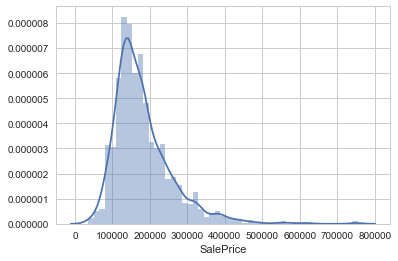

In [80]:
# Distribution of SalePrice
seaborn.distplot(data_sets['df_train']['SalePrice'])

print("Skewness: {}".format(df_train['SalePrice'].skew()))
data_sets['df_train'][['SalePrice']].describe()

In [81]:
# We first take a look at the categorical (and ordinal) variables (up to 12 unique values)
data_sets['df_train'].nunique().sort_values().iloc[:20]

CentralAir      2
Street          2
Utilities       2
HalfBath        3
PavedDrive      3
Alley           3
BsmtHalfBath    3
LandSlope       3
PoolQC          4
BsmtFullBath    4
FullBath        4
KitchenAbvGr    4
ExterQual       4
LandContour     4
LotShape        4
Fireplaces      4
GarageFinish    4
KitchenQual     4
ExterCond       5
MiscFeature     5
dtype: int64

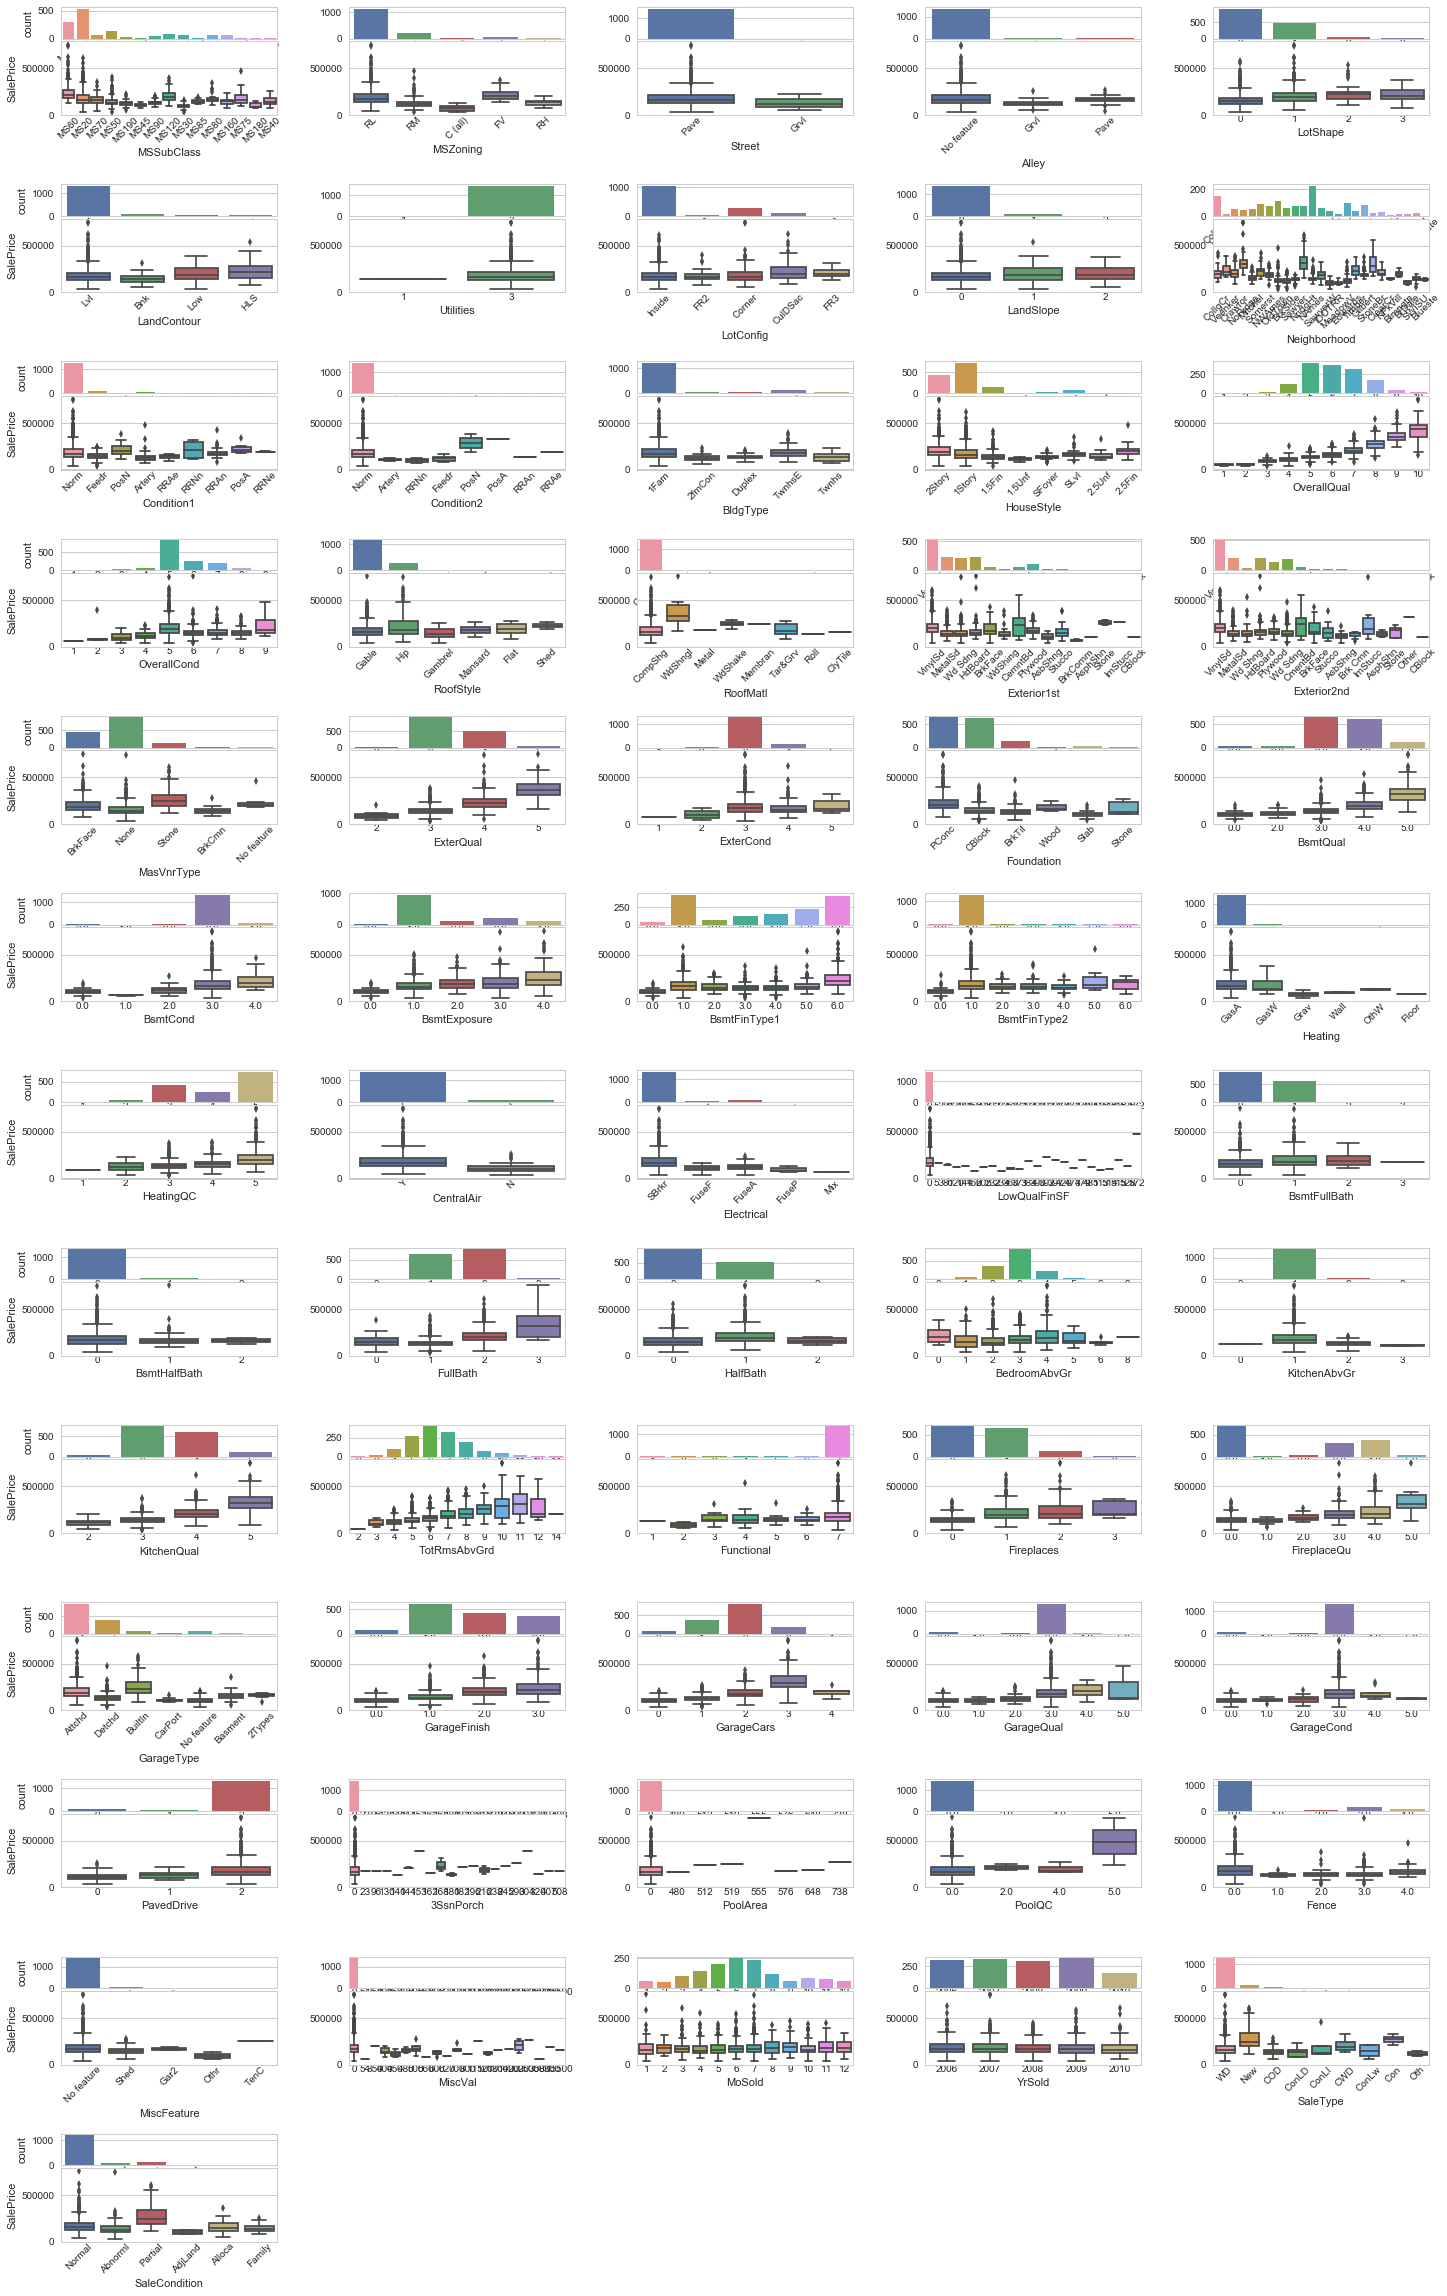

In [82]:
# We observe the relation between SalePrice and all the categorical variables, while checking their distribution
plot_boxplot_with_hist(data_sets['df_train'])

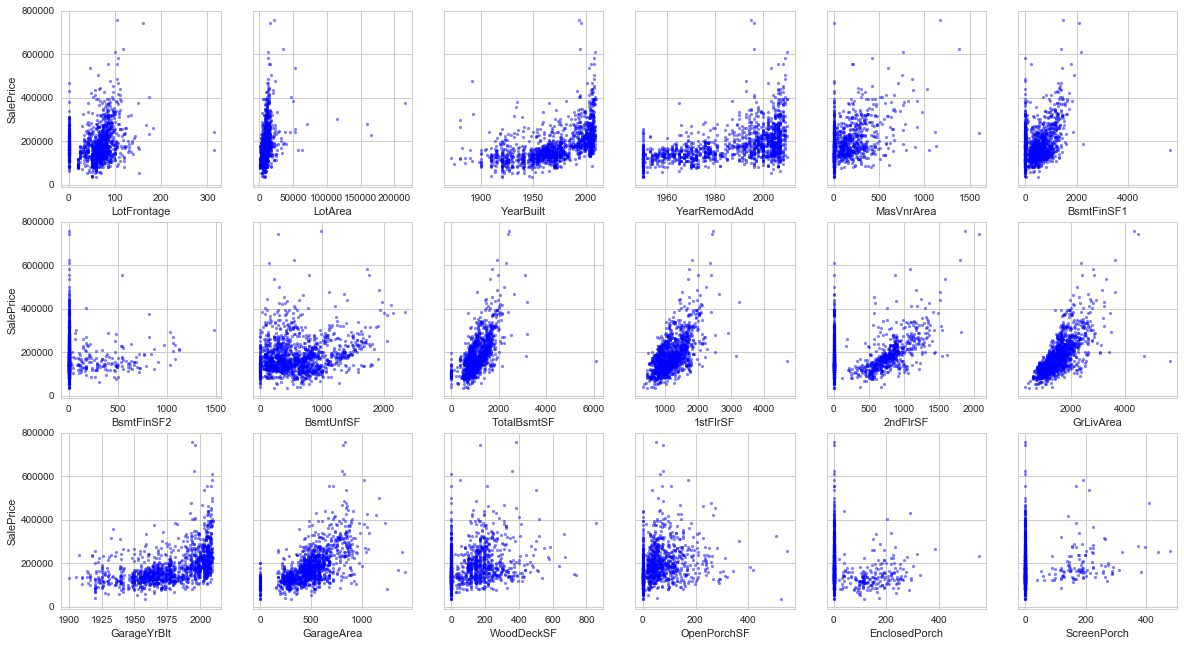

In [83]:
# Pairwise relations between SalePrice and continuous features
plot_pairwise_with_target(data_sets['df_train'])

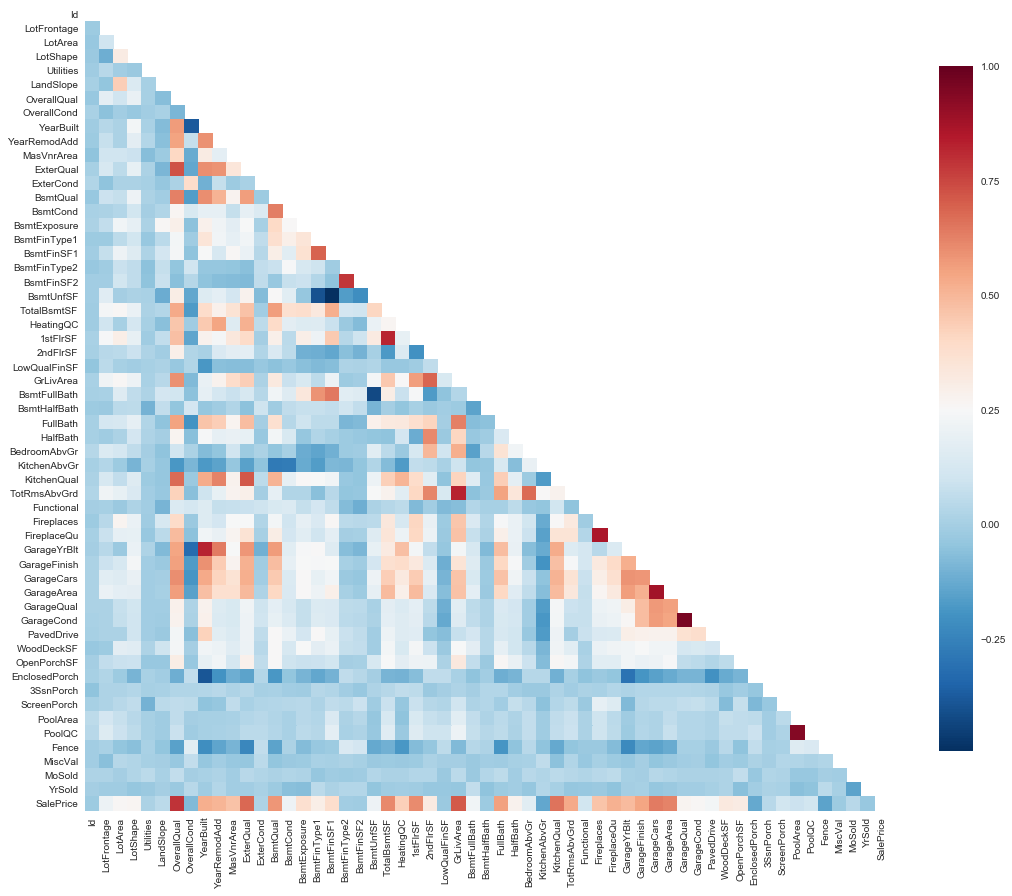

In [84]:
# Linear correlations between numerical features
plot_correlation_map(data_sets['df_train'])

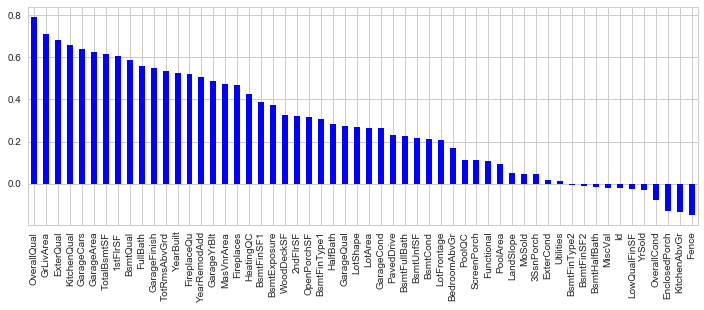

In [85]:
data_sets['df_train'].corr()['SalePrice'].sort_values(ascending=False).iloc[1:].plot(kind='bar', figsize=(12, 4), color='b')

# II) Data Engineering

- Combine related Variables together


- Handle actual missing values


- Log transform skewed data


- Encode categorical features into dummy variables


### Combine related Variables together

- We merge related features together to reduce the overall number of features. For example we combine `YrSold` and `MoSold` into one feature, and `FullBath`and `HalfBath` into another one.


- We drop some features that are too correlated together, and keep the ones that (seemingly) carry more information. For instance we keep `GarageCars` and drop `GarageAera` which could be more volatile, and which is slighlty less correlated to the target.


- We then plot the correlation matrix to check that there are not too strong correlations remaining among the numerical features. 

In [86]:
for key, df in data_sets.items():
    
    print(f'Data set being processed: {key}')
    
    # 'YearSold' and 'MoSold' into 'YrsFromSale' (we take latest year 2010 as a reference).
    # Same for 'YearBuilt' which we transform into 'YrsFromConst' (better interpretable).
    df = df.assign(
        TimeFromSale=2010 - df['YrSold'] + (12 - df['MoSold']) / 12,
        YrsFromConst=2010 - df['YearBuilt'],
        YrsFromRemod=2010 - df['YearRemodAdd'], 
    ).drop(['YrSold', 'MoSold', 'YearBuilt', 'YearRemodAdd'], axis=1)
    
    # Combine the freshly created 'YrsFromConst' and 'YrsFromRemod' into a single feature (take the mean)
    df = df.assign(
        YrsFromCombined=0.5 * (df['YrsFromConst'] + df['YrsFromRemod']),
    ).drop(['YrsFromConst', 'YrsFromRemod'], axis=1)
        
    # Combine 'FullBath' and 'HalfBath' into BathTot (same for 'BsmtFullBath' and 'BsmtHalfBath').
    df = df.assign(
        BathTot=lambda x: x['FullBath'] + 0.5 * x['HalfBath'],
        BsmtBathTot=lambda x: x['BsmtFullBath'] + 0.5 * x['BsmtHalfBath'],
    ).drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)
    
    # Combine highly correlated features with underlying logic ('GarageQual' and 'GarageCond').
    df = df.assign(
        FirePlaceScore=lambda x: x['Fireplaces'] * x['FireplaceQu'],
        GarageScore=lambda x: x['GarageQual'] * x['GarageCond'],
    ).drop(['Fireplaces', 'FireplaceQu', 'GarageQual', 'GarageCond'], axis=1)
    
    # MasVnrType
    mapping = {'None': 0, 'No feature': 0, 'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1}
    df = df.assign(
        MasVnrType=df['MasVnrType'].replace(mapping),
        MasVnrTypeScore=lambda x: x['MasVnrType'] * x['MasVnrArea']
    ).drop(['MasVnrArea', 'MasVnrType'], axis=1)
    
    # BsmtScore
    df = df.assign(
        BsmtFinScore1=df['BsmtFinSF1'] * df['BsmtFinType1'],
        BsmtFinScore2=df['BsmtFinSF2'] * df['BsmtFinType2'],
    ).drop(['BsmtFinSF1', 'BsmtFinType1', 'BsmtFinSF2', 'BsmtFinType2'], axis=1)
    
    # 'GarageCars' and 'GarageArea' highly correlated (almost 0.9 on df_train!).
    # We choose to drop 'GarageArea' which is slightly less correlated with the target.
    # 'GarageYrBlt' is correlated with 'YearBuilt' and there is no obvious way to deal with the missing values.
    # We choose to drop it.
    df = df.drop(['GarageArea', 'GarageYrBlt'], axis=1)
    
    # Drop 'PoolArea' as the feature is too correlated to 'PoolQC'
    # and according to box plots the relation between 'SalePrice' and 'PoolQC' seems more robust
    df = df.drop(['PoolArea'], axis=1)
    
    # Drop 'BsmtFinType2' as too correlated with 'BsmtFinSF2'
    # Same thing for 'TotalBsmtSF' too correlated with '1stFlrSF' (which has more non zero values)
    df = df.drop(['TotalBsmtSF'], axis=1)
    
    # Drop 'TotRmsAbvGrd' as too correlated with 'GrLivArea'
    df = df.drop(['TotRmsAbvGrd'], axis=1)
    
    data_sets[key] = df
    
    print(f'Data set processed successfully: {key}')

Data set being processed: df_train
Data set processed successfully: df_train
Data set being processed: df_test
Data set processed successfully: df_test


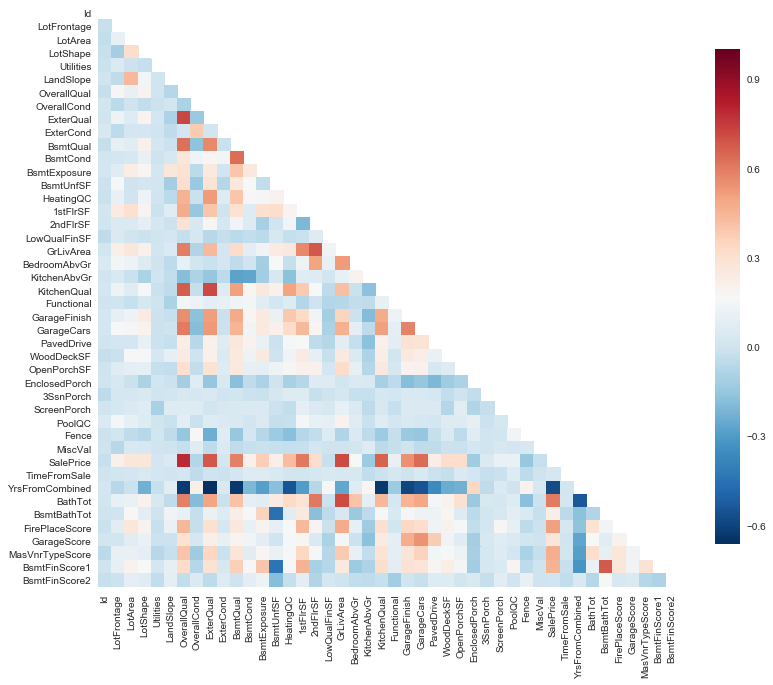

In [87]:
plot_correlation_map(data_sets['df_train'], figsize=(13, 13))

### Handle actual missing values 

There are a few remaining missing values in the test_set for some categorical features (`MsZoning`, `Utilites`, `Exteriort1st`...). Here the absence of value doesn't really correspond to the absence of feature. There is no obvious way to interpret those. 

We therefore need to fill those before encoding the categories into dummy variables ; we choose to do it by using the most frequent category.

In [88]:
modes_train = data_sets['df_train'].select_dtypes('object').mode().iloc[0]

for key, df in data_sets.items():
    
    print(f'Data set being processed: {key}')
    
    temp = df.select_dtypes('object').isnull().any(axis=0)
    print(temp[temp].index)
    data_sets[key] = df.select_dtypes('object').fillna(modes_train).join(df.select_dtypes(exclude=['object']))
                                                                                     
    print(f'Data set processed successfully: {key} \n')
    
    
del modes_train, temp

Data set being processed: df_train
Index(['Electrical'], dtype='object')
Data set processed successfully: df_train 

Data set being processed: df_test
Index(['MSZoning', 'Exterior1st', 'Exterior2nd', 'SaleType'], dtype='object')
Data set processed successfully: df_test 



### Log transform skewed data

This step of the process is optional. One of the main reasons to log transform skewed numerical variables is to make them more robust to outliers: the impact of an extreme value x will be lighten when considering log(1 + x). Besides it increases the performance of the model on the train and test sets.

Here the square feet-related features (which are skewed) are the ones subject to outliers. 

In [89]:
data_sets['df_train'].select_dtypes(['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 44 columns):
Id                 1460 non-null int64
LotFrontage        1460 non-null float64
LotArea            1460 non-null int64
LotShape           1460 non-null int64
Utilities          1460 non-null int64
LandSlope          1460 non-null int64
OverallQual        1460 non-null int64
OverallCond        1460 non-null int64
ExterQual          1460 non-null int64
ExterCond          1460 non-null int64
BsmtQual           1460 non-null float64
BsmtCond           1460 non-null float64
BsmtExposure       1460 non-null float64
BsmtUnfSF          1460 non-null int64
HeatingQC          1460 non-null int64
1stFlrSF           1460 non-null int64
2ndFlrSF           1460 non-null int64
LowQualFinSF       1460 non-null int64
GrLivArea          1460 non-null int64
BedroomAbvGr       1460 non-null int64
KitchenAbvGr       1460 non-null int64
KitchenQual        1460 non-null int64
Functional         1460 non

In [92]:
# compute skewness on df_train
skewed_feats = data_sets['df_train'].select_dtypes(['int64', 'float64']).drop('SalePrice', axis=1).apply(lambda x: scipy.stats.skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 1]
skewed_feats = list(skewed_feats.index)
print(skewed_feats)

# Remove the categorical variables from the list (it's definitely not a nice way to do it)
for feature in ['LotShape', 'LandSlope', 'ExterCond', 'BsmtExposure', 'KitchenAbvGr', 'PoolQC', 'Fence', 'MasVnrTypeScore',
                'BsmtFinScore1', 'BsmtFinScore2']:
    skewed_feats.remove(feature)
    

# Remove the skewed (and continuous) features from both data sets
for key, df in data_sets.items():
    print(f'Data set being processed: {key}')
    df[list(skewed_feats)] = numpy.log1p(df[list(skewed_feats)])
    print(f'Data set processed successfully: {key} \n')

['LotArea', 'LotShape', 'LandSlope', 'ExterCond', 'BsmtExposure', '1stFlrSF', 'LowQualFinSF', 'GrLivArea', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'Fence', 'MiscVal', 'MasVnrTypeScore', 'BsmtFinScore1', 'BsmtFinScore2']


### Create dummy variables for categories of each nominal column

We finally have the data sets ready to fit a model, they both have 200 features.

In [93]:
# Encode categorical columns into dummy variables
for key, df in data_sets.items():
    
    print(f'Data set being processed: {key}')
    
    columns_to_process = df.select_dtypes(include='object').columns
    other_columns = df.select_dtypes(exclude='object').columns
    
    data_sets[key] = df.loc[:, other_columns].join(pandas.get_dummies(df.loc[:, columns_to_process], drop_first=True))
                                                                                                                                  
    print(f'Data set processed successfully: {key}')
    
    
# There are categories in df_train that don't appear in df_test.
# We therefore have to add the corresponding columns in df_test and fill the column with 0.
# Besides there is an additional column in df_test ('MSSubClass_MS150') which we drop.
def complete_df_test():
    cols_dict = {}
    for col in data_sets['df_train'].columns.drop('SalePrice'):
        if not(col in data_sets['df_test'].columns):
            cols_dict[col] = lambda x: 0
    data_sets['df_test'] = data_sets['df_test'].assign(**cols_dict).drop(['MSSubClass_MS150'], axis=1)
    
complete_df_test()

Data set being processed: df_train
Data set processed successfully: df_train
Data set being processed: df_test
Data set processed successfully: df_test


In [94]:
data_sets['df_train'].shape, data_sets['df_test'].shape

((1460, 201), (1459, 200))

# III)} Modelling

- Pre-feature selection


- Cross-validation for hyperparameters and model fitting 

In [95]:
# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Pipeline
from sklearn.pipeline import Pipeline

# Model Selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

### Pre-feature selection

We now have 200 features, which is a large number relatively to the size of our train set. We therefore want to decrease the dimensionality by doing a feature selection before fitting a regressor. The main reason behind this step is to avoid overfitting. Additionnally it speeds up the fitting process. 

The random forest regressor is a convenient way to measure feature importance. 
Here we use a function running a random forest regressor on the entire train set. This function takes `threshold_mult` as an argument that allows to select the level of selectivity we want to apply. And we use SelectFromModel from sklearn to make the selection directly. 

In [117]:
def generate_train_test_with_preselection(threshold_mult=2, plot=True):
    
    # We use log(SalePrice) as a target since the evaluation metric is the RMSE on log(SalePrice)
    y_train = numpy.log(data_sets['df_train']['SalePrice'])
    X_train = data_sets['df_train'].drop(['SalePrice', 'Id'], axis=1)
    X_test = data_sets['df_test'].loc[:, list(X_train.columns)].copy()
    assert (X_train.columns == X_test.columns).all(), 'At least one mismatch in the columns ordering'
    
    # Fit randome forest regressor and plot feature importance
    reg = RandomForestRegressor(n_estimators=100, criterion='mse', max_features='sqrt', random_state=42)
    reg = reg.fit(X_train, y_train)

    df = pandas.DataFrame({
        'features': X_train.columns,
        'importance': reg.feature_importances_,
    }).sort_values('importance', ascending=True)
    
    threshold = threshold_mult * df['importance'].mean()
    if plot:
        fig, ax = pyplot.subplots(figsize=(15, 34))
        df.plot(y='importance', x='features', kind='barh', color='b', ax=ax)
        ax.axvline(threshold, linestyle='--', color='black')
        pyplot.show()
        
    # Pre feature selection
    features_selector = SelectFromModel(reg, prefit=True, threshold=threshold)
    reduced_X_train = X_train[X_train.columns[features_selector.get_support(indices=True)]]
    reduced_X_test = X_test[X_test.columns[features_selector.get_support(indices=True)]]
            
    return reduced_X_train, y_train, reduced_X_test


# We also define a score function that returns directly the rmse (SalePrice is already log-transformed)
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

rmse_score = make_scorer(rmse, greater_is_better=False)

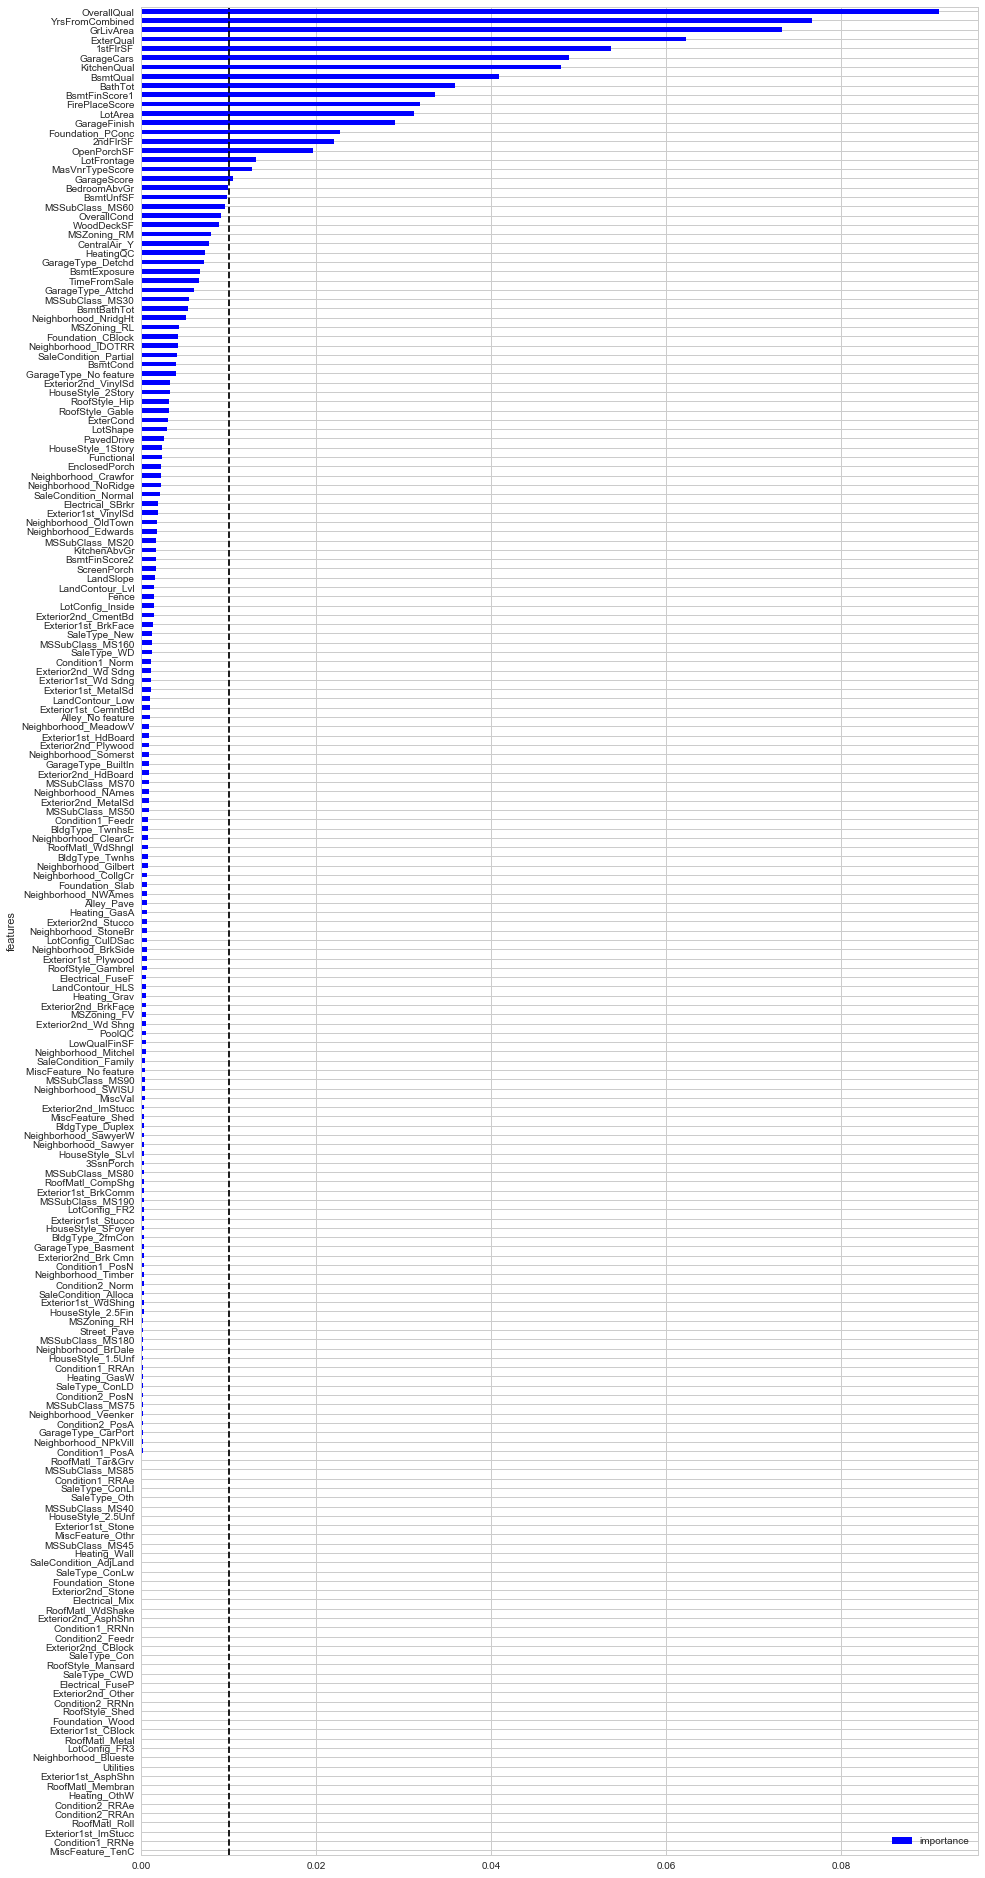

In [118]:
_ = generate_train_test_with_preselection()

###  Hyperparameters tuning and model fitting

Here we compare two different estimators: the random forest and the ridge regression.

The former gives really good results on the train set but there is a big drawdown when running predictions on the test set. In the current configuration it would indicate an overfitting, in spite of the cross-validation.

The ridge regressor is more stable and gives good results on the test set (public leaderboard). A few modifications (I'll let you try!) can improve the results signficantly on both the train and test sets. For example adding polynomial features for the most important features is a good start.

**Random Forest**

In [121]:
reduced_X_train, y_train, reduced_X_test = generate_train_test_with_preselection(threshold_mult=.2, plot=False)

reg = RandomForestRegressor()
parameter_grid = {
                 'max_depth' : [4, 6, 8, 10, 14],
                 'max_features': ['sqrt'],
                 'min_samples_split': [3, 5, 10],
                 'min_samples_leaf': [3, 5, 10],
                 }
cross_validation = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=reg, param_grid=parameter_grid, cv=cross_validation, scoring=rmse_score, refit=True)
grid_search.fit(reduced_X_train, y_train) 

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best estimator: {}'.format(grid_search.best_estimator_))

Best score: -0.15159805360821457
Best parameters: {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5}
Best estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [122]:
# Validation score and comparions with CV scores
pred_validation = grid_search.predict(reduced_X_train) 
print('validation_rmse: {}'.format(math.sqrt(mean_squared_error(pred_validation, y_train))))

validation_rmse: 0.10687674671226148


In [123]:
output = grid_search.predict(reduced_X_test)
output = numpy.exp(output)

pandas.DataFrame(index=data_sets['df_test']['Id'], data=output, columns=['SalePrice']).to_csv('rf_submission.csv')

**Ridge regression**

In [140]:
reduced_X_train, y_train, reduced_X_test = generate_train_test_with_preselection(plot=False, threshold_mult=.1)

pipe = Pipeline([
    ('scaler', RobustScaler(with_centering=False)),
    ('estimator', Ridge(fit_intercept=True, normalize=False)),
])

alphas = [0.01, 0.05, 0.1, 0.3, 0.5, 1, 2, 3, 5, 8, 10, 12, 14, 16, 18, 30, 40, 50]
parameter_grid = {'estimator__alpha': alphas}
cross_validation = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipe, param_grid=parameter_grid, cv=cross_validation, scoring=rmse_score, refit=True, return_train_score=True)
grid_search.fit(reduced_X_train, y_train) 

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best estimator: {}'.format(grid_search.best_estimator_))

Best score: -0.1318508263200481
Best parameters: {'estimator__alpha': 30}
Best estimator: Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
       with_scaling=True)), ('estimator', Ridge(alpha=30, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])


validation_rmse: 0.11682514240093843


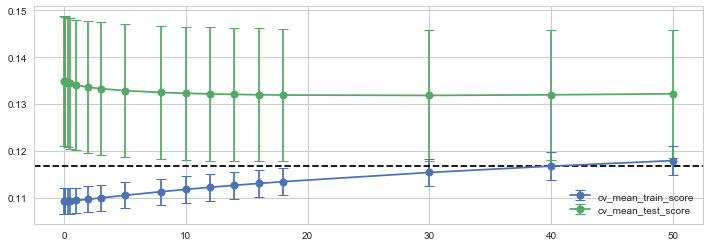

In [141]:
# Validation score and comparions with CV scores
pred_validation = grid_search.predict(reduced_X_train) 
entire_train_score = math.sqrt(mean_squared_error(pred_validation, y_train))
print('validation_rmse: {}'.format(entire_train_score))

fig, ax = pyplot.subplots(figsize=(12, 4))
pyplot.rcParams.update({'lines.markeredgewidth': 1})
ax.errorbar(alphas, -grid_search.cv_results_['mean_train_score'], yerr=0.5*grid_search.cv_results_['std_train_score'], 
                fmt='-o', capsize=5, label='cv_mean_train_score')
ax.errorbar(alphas, -grid_search.cv_results_['mean_test_score'], yerr=0.5*grid_search.cv_results_['std_test_score'], 
                fmt='-o', capsize=5, label='cv_mean_test_score')
ax.axhline(entire_train_score, linestyle='--', color='black')
pyplot.legend()
pyplot.show()

In [37]:
output = grid_search.predict(reduced_X_test)
output = numpy.exp(output)

pandas.DataFrame(index=data_sets['df_test']['Id'], data=output, columns=['SalePrice']).to_csv('submission.csv')